In [39]:
import tensorflow as tf
from tensorflow import keras
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime
print(tf.__version__)

2.1.0


# 加载MNIST数据集

In [40]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


# 数据预处理

In [41]:
def normalize(x, y):
    x = tf.cast(x, tf.float32)
    x /= 255
    return x, y

In [42]:
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1) # 扩充channel通道维度
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(normalize)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(normalize)
print(train_dataset)
print(test_dataset)

<MapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.uint8)>
<MapDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.uint8)>


# 数据可视化

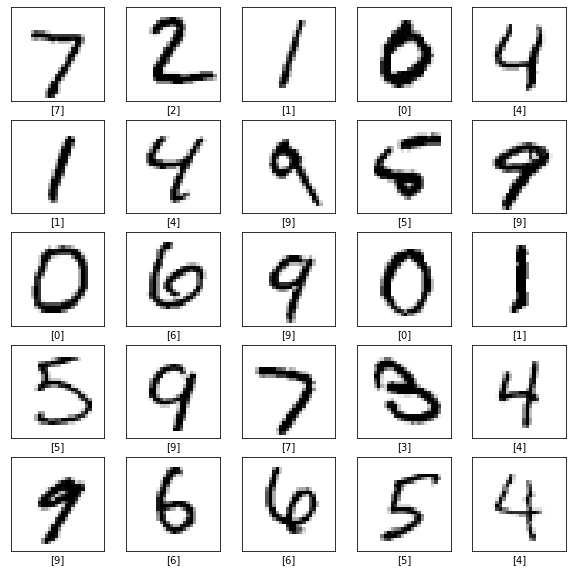

In [44]:
plt.figure(figsize=(10, 10))
i = 0
for (x_test, y_test) in test_dataset.take(25):
    x_test = x_test.numpy().reshape((28, 28))
    plt.subplot(5, 5, i+1)
    plt.xticks([]) # 去掉坐标轴
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test, cmap=plt.cm.binary)
    plt.xlabel([y_test.numpy()])
    i += 1
plt.show()

# 定义模型

In [45]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28,1)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


# 编译模型

In [46]:
model.compile(optimizer='sgd', 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['sparse_categorical_accuracy'])

# 训练模型

In [47]:
batch_size=32
train_dataset = train_dataset.repeat().shuffle(60000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
print(train_dataset)
log_dir = 'logs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(60000 / batch_size))

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>
Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6170 - sparse_categorical_accuracy: 0.8333
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2935 - sparse_categorical_accuracy: 0.9155
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9308
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2029 - sparse_categorical_accuracy: 0.9424
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9481
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9539
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1419 - sparse_categorical_accuracy: 0.9594
Epoch 8/10
1875/1875 [===========================

# 模型评估

In [48]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(10000/32))

313/313 [==============================] - 1s 2ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9653


# 模型预测

In [49]:
predictions = model.predict(test_dataset)
predictions.shape

(10000, 10)

# 预测结果可视化

In [50]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel('{} {:2.0f}% ({})'.format(predicted_label,
                                        100 * np.max(predictions_array),
                                        true_label), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

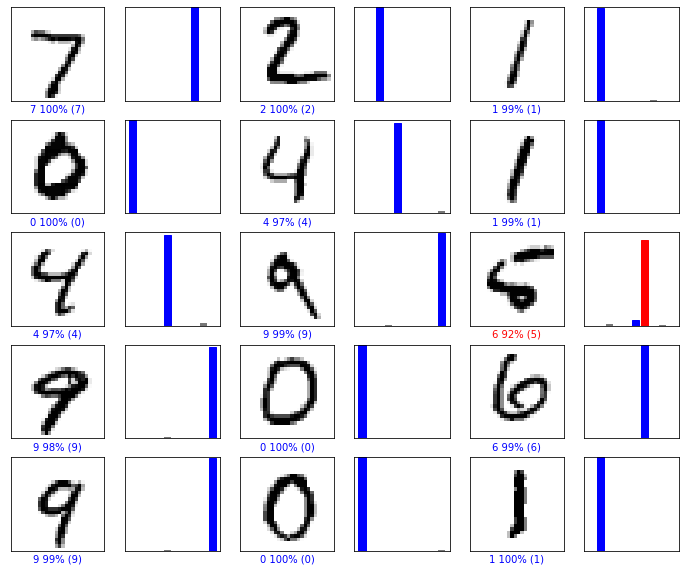

In [51]:
num_cols = 3
num_rows = 5
num_images = num_cols * num_rows
for test_imgages, test_labels in test_dataset.take(1):
    test_imgages = test_imgages.numpy()
    test_labels = test_labels.numpy()

plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_imgages)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
    